# Задание 3. Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [46]:
from __future__ import annotations
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import math
from scipy.optimize import fmin_tnc
%matplotlib inline


In [47]:
df = pd.read_csv('Task4_data/lin_reg.txt', header=None, names=['x1','x2','x3','x4','y'])
df.head()

,x1,x2,x3,x4,y
0,9.310,-17.043,20.807,11.109,-165.864
1,-6.446,-12.460,-12.941,-14.715,-49.048
2,14.324,-9.624,29.533,1.439,-161.183
3,-19.511,9.563,-38.774,-1.116,177.828
4,-5.917,3.696,-11.428,13.364,40.092


In [48]:
def X_Y_split(df: pd.DataFrame) -> tuple[np.array, np.array]:
    return df.iloc[:,:-1].values, df.iloc[:, -1].values


def random_train_test_split(df: pd.DataFrame, train_size: float = 0.8, random_state: int = 42) -> tuple[np.array, np.array]:
    train = df.sample(frac = train_size, random_state = random_state)
    test = df.drop(index = train.index)
    x_train, y_train = X_Y_split(train)
    x_test, y_test = X_Y_split(test)
    return x_train, y_train, x_test, y_test


def train_validation_split(df: pd.DataFrame, val_slice: slice) -> tuple[np.array, np.array]:
    validation = df[val_slice]
    train = df.drop(index = validation.index)
    x_train, y_train = X_Y_split(train)
    x_val, y_val = X_Y_split(validation)
    return x_train, y_train, x_val, y_val


def forward_pass(theta: np.array, x: np.array):
    x = np.hstack((np.ones((x.shape[0], 1)), x))
    return (x @ theta)


def loss_func(theta: np.array, x: np.array, y: np.array, alpha: float = 0):
    x = np.hstack((np.ones((x.shape[0], 1)), x))
    return np.sum(np.power((x @ theta) - y, 2)) / len(y) + alpha * np.sum(np.power(theta,2))


def loss_func_grad(theta: np.array, x: np.array, y: np.array, alpha: float = 0):
    x = np.hstack((np.ones((x.shape[0], 1)), x))
    return x.T @ (x @ theta - y) + alpha * theta


def fit_linear(x: np.array, y: np.array, alpha: float = 0):
    history = {'theta': [], 'error': []}

    def callback(theta):
        history['theta'].append(theta)
        history['error'].append(loss_func(theta, x, y, alpha))
    
    #optimal_theta = minimize(loss_func, x0=np.zeros((x.shape[1]+1, 1)),
                         #args=(x, y, alpha), callback=callback, method='BFGS').x
    optimal_theta = fmin_tnc(loss_func, x0 =np.ones((x.shape[1]+1, 1)),
                         fprime = loss_func_grad, args = (x, y, alpha), callback = callback, disp = 0, approx_grad=False)[0]
    return optimal_theta, history

In [49]:
def cross_val(df, nfold = 5, alpha = 0):
    shaffled_df = df.sample(frac=1, random_state = 42) 
    slice_size = df.shape[0]//nfold
    val_loss = []
    for i in range(0, df.shape[0], slice_size):
        val_slice = slice(i, i+slice_size)
        x_train, y_train, x_val, y_val = train_validation_split(shaffled_df, val_slice)
        optimal_theta, _ = fit_linear(x_train, y_train, alpha = alpha)
        val_loss.append(loss_func(optimal_theta, x_val, y_val, alpha = alpha))
    return sum(val_loss)/len(val_loss)

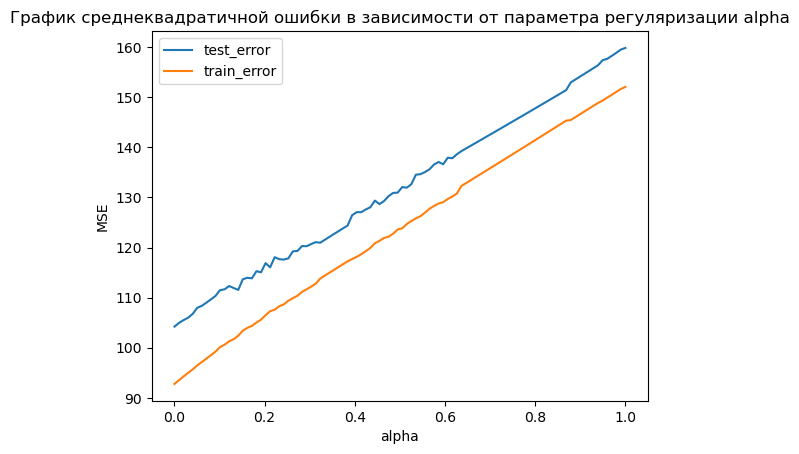

In [50]:
def MSE_by_alpha(df):
    x_train, y_train, x_test, y_test = random_train_test_split(df)
    errors = {'train_error': [], 'test_error': []}
    alpha_range = np.linspace(0, 1, 100)
    for alpha in alpha_range:
        optimal_theta, _ = fit_linear(x_train, y_train, alpha = alpha)
        errors['train_error'].append(loss_func(optimal_theta, x_train, y_train, alpha = alpha))
        errors['test_error'].append(loss_func(optimal_theta, x_test, y_test, alpha = alpha))
    
    plt.plot(alpha_range, errors['test_error'], label = 'test_error')
    plt.plot(alpha_range, errors['train_error'], label = 'train_error')
    plt.legend()
    plt.title('График среднеквадратичной ошибки в зависимости от параметра регуляризации alpha')
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.show()

MSE_by_alpha(df)

оптимальное alpha 0.0
mse 96.0454261186849


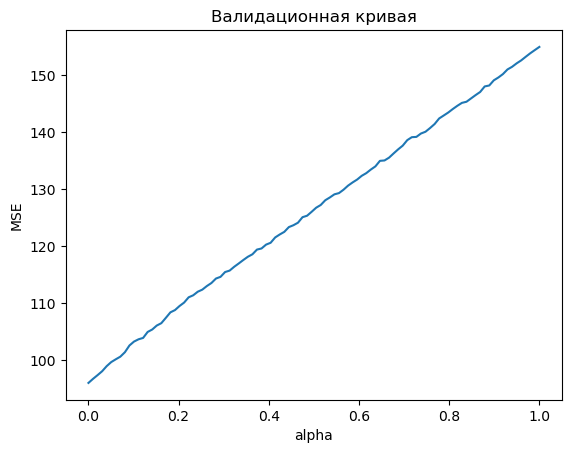

In [51]:
mean_errors = {}
for a_temp in np.linspace(0, 1, 100):
    cv_loss = cross_val(df, alpha = a_temp)
    mean_errors[a_temp] = cv_loss
min_val = sorted(mean_errors.items(), key = lambda x: x[1])[0]
optimal_alpha = min_val[0]
print('оптимальное alpha', min_val[0])
print('mse', min_val[1])
plt.plot(mean_errors.keys(), mean_errors.values())
plt.title('Валидационная кривая')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

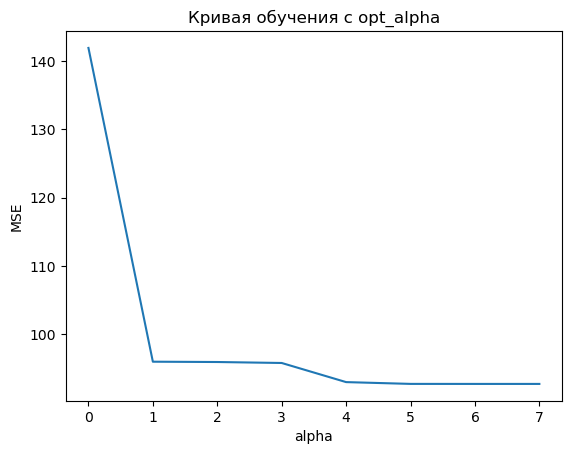

In [52]:
    
x_train, y_train, x_test, y_test = random_train_test_split(df)
theta, history = fit_linear(x_train, y_train, optimal_alpha)
plt.plot(history['error'])
plt.title('Кривая обучения с opt_alpha')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()